In [1075]:
import pandas as pd

total = 0
cities = ["bronx", "brooklyn", "manhattan", "queens", "staten_island"]
for i in cities:
    year = 2022
    while year <= 2024:
        df = pd.read_csv(f"{year}_{i}.csv")
        print("="*60)
        print (f"Data for {i} in {year}:")
        print("="*60)
        print(df.head())
        year += 1
        total +=1

print(total)

# quick scan to see if all xlsx files have been convered to csv correctly, and edits for column names applied smoothly

Data for bronx in 2022:
   BOROUGH NEIGHBORHOOD  BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
0        2     BATHGATE  01 ONE FAMILY DWELLINGS                    1   2905   
1        2     BATHGATE  01 ONE FAMILY DWELLINGS                    1   3028   
2        2     BATHGATE  01 ONE FAMILY DWELLINGS                    1   3030   
3        2     BATHGATE  01 ONE FAMILY DWELLINGS                    1   3037   
4        2     BATHGATE  01 ONE FAMILY DWELLINGS                    1   3039   

   LOT  EASE-MENT BUILDING CLASS AT PRESENT                 ADDRESS  \
0   26        NaN                        A9  1667 WASHINGTON AVENUE   
1   24        NaN                        A1   410 EAST 179TH STREET   
2   65        NaN                        A1        4455 PARK AVENUE   
3  101        NaN                        S0     443 EAST 180 STREET   
4   29        NaN                        A5     2327 WASHINGTON AVE   

  APARTMENT NUMBER  ...  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL 

**Part 1**

Step 1: Merging into one large CSV



In [1076]:
#TODO: add a city column, and fill all rows with "city"
#TODO: add a year column, and fill all rows with "year"

bouroughs = ["bronx", "brooklyn", "manhattan", "queens", "staten_island"]
years = [2022, 2023, 2024]
all_data = []

for bourough in bouroughs:
    for year in years:
        df = pd.read_csv(f"{year}_{bourough}.csv")
        
        #add a city column, and fill all rows with "city"
        #add a year column, and fill all rows with "year"
        df['YEAR'] = year
        df['BOUROUGH'] = bourough
    
        all_data.append(df)

# just merge vertically using pd.concat (more memory efficent)
all = pd.concat(all_data, ignore_index=True)


1. a) summary of the dataset


In [1077]:
print("="*60)
print(f"dataset general info:{all.info()}")
print("="*60)
print(f"shape of the dataset:{all.shape}")
print("="*60)
print(all.shape)
print("="*60)
print(f"central tendency of dataset {all.describe()}")
print("="*60)
print(f"unique values in each column {all.nunique()}")
print("="*60)
print(f"total number of NaN values: {all.isna().sum().sum()}")
print("="*60)
print(f"number of missing values in each column: {all.isna().sum().sort_values(ascending=False)}")
print("="*60)



<class 'pandas.DataFrame'>
RangeIndex: 243503 entries, 0 to 243502
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   BOROUGH                         243503 non-null  int64  
 1   NEIGHBORHOOD                    243503 non-null  str    
 2   BUILDING CLASS CATEGORY         243503 non-null  str    
 3   TAX CLASS AT PRESENT            243327 non-null  str    
 4   BLOCK                           243503 non-null  int64  
 5   LOT                             243503 non-null  int64  
 6   EASE-MENT                       0 non-null       float64
 7   BUILDING CLASS AT PRESENT       243327 non-null  str    
 8   ADDRESS                         243503 non-null  str    
 9   APARTMENT NUMBER                59176 non-null   str    
 10  ZIP CODE                        243483 non-null  float64
 11  RESIDENTIAL UNITS               183961 non-null  object 
 12  COMMERCIAL UNITS           

1. b) Identify and discuss data quality issues (e.g., missing values,
duplicates, inconsistencies).

DUPLICATE COLUMNS:

In [1078]:
#from the output above, it appears that there exists naming error in columns

all.columns = all.columns.str.strip()

#specifcally seems like there are duplicate columns, specifcaaly borough and eastment columns. manage accordingly
all.drop(columns=['BOROUGH'], inplace=True)
all.drop(columns=['EASEMENT'], inplace=True)

print("new shape:")
all.shape


new shape:


(243503, 22)

MISSING VALUES:

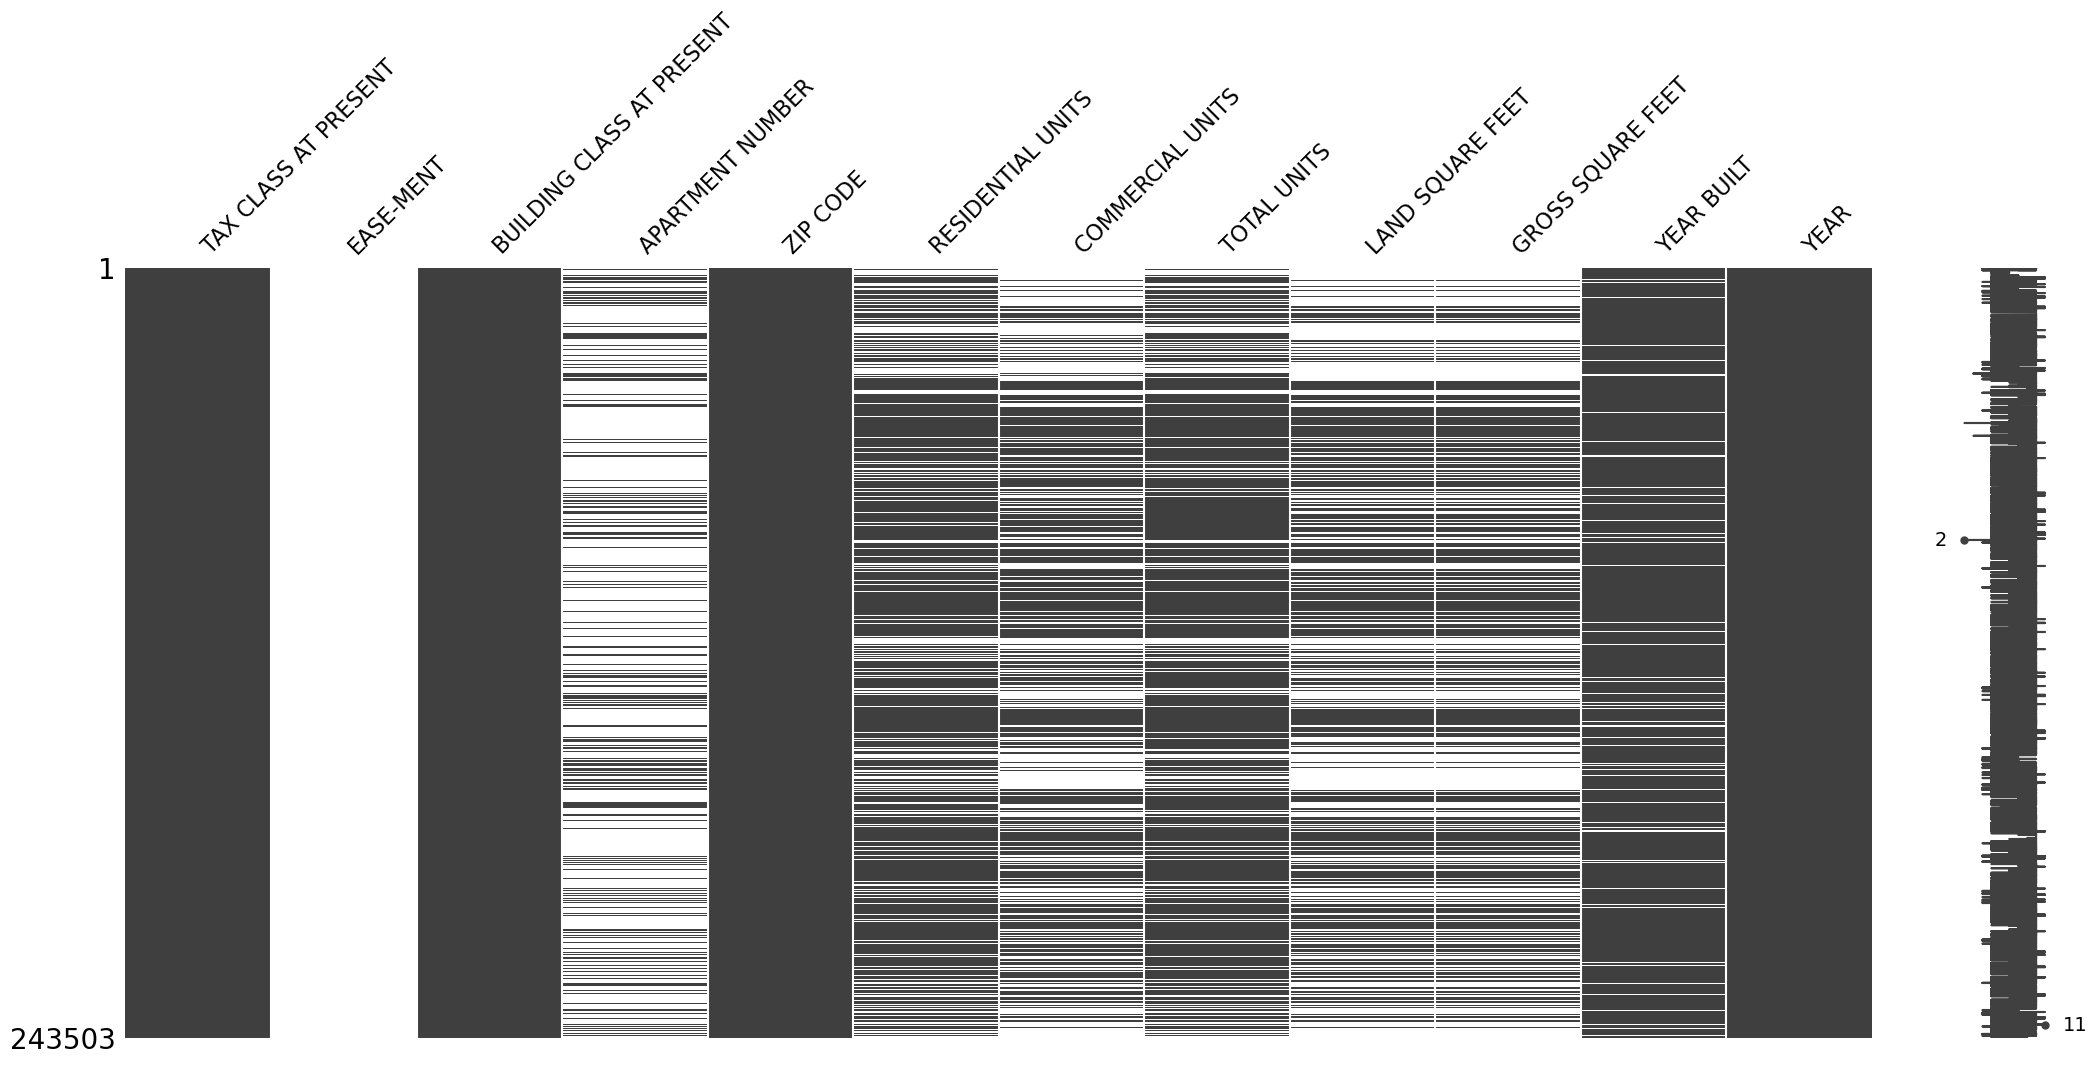

In [1079]:
import missingno as msno
import matplotlib.pyplot as plt

cols_with_missing = all.columns[all.isnull().any()].to_list()
cols_with_missing.append('YEAR')

msno.matrix(all[cols_with_missing].sort_values('YEAR'))
plt.show()





In [1080]:
#looks like easement columns are all NaN, verify
all[['EASE-MENT']].isna().all()

#an easement is a legal right allowing someone to use another person's property for a specific purpose, 
#like a utility company running lines under your land or a neighbor using your driveway for access, without owning it. 
#depending on the context of the goal of analysis, easements may not be relevant. In the cases that easement may be relevant
#values may be calculated or roughly estimated via other features. For the purposes of this assignment, assuming it is best
#to stick to more basic straight-forward features, and particularly in this case, since all values are NaN, drop these columns.

#drop easement columns
all = all.drop(['EASE-MENT'], axis=1)

#furtheremore columns that are > 80% missing
threshold = len(all) * 0.8
all = all.dropna(thresh=threshold, axis=1)




Missing ZIPs after Address lookup: 20
Missing ZIPs after Address lookup: 8
Missing ZIPs: 0


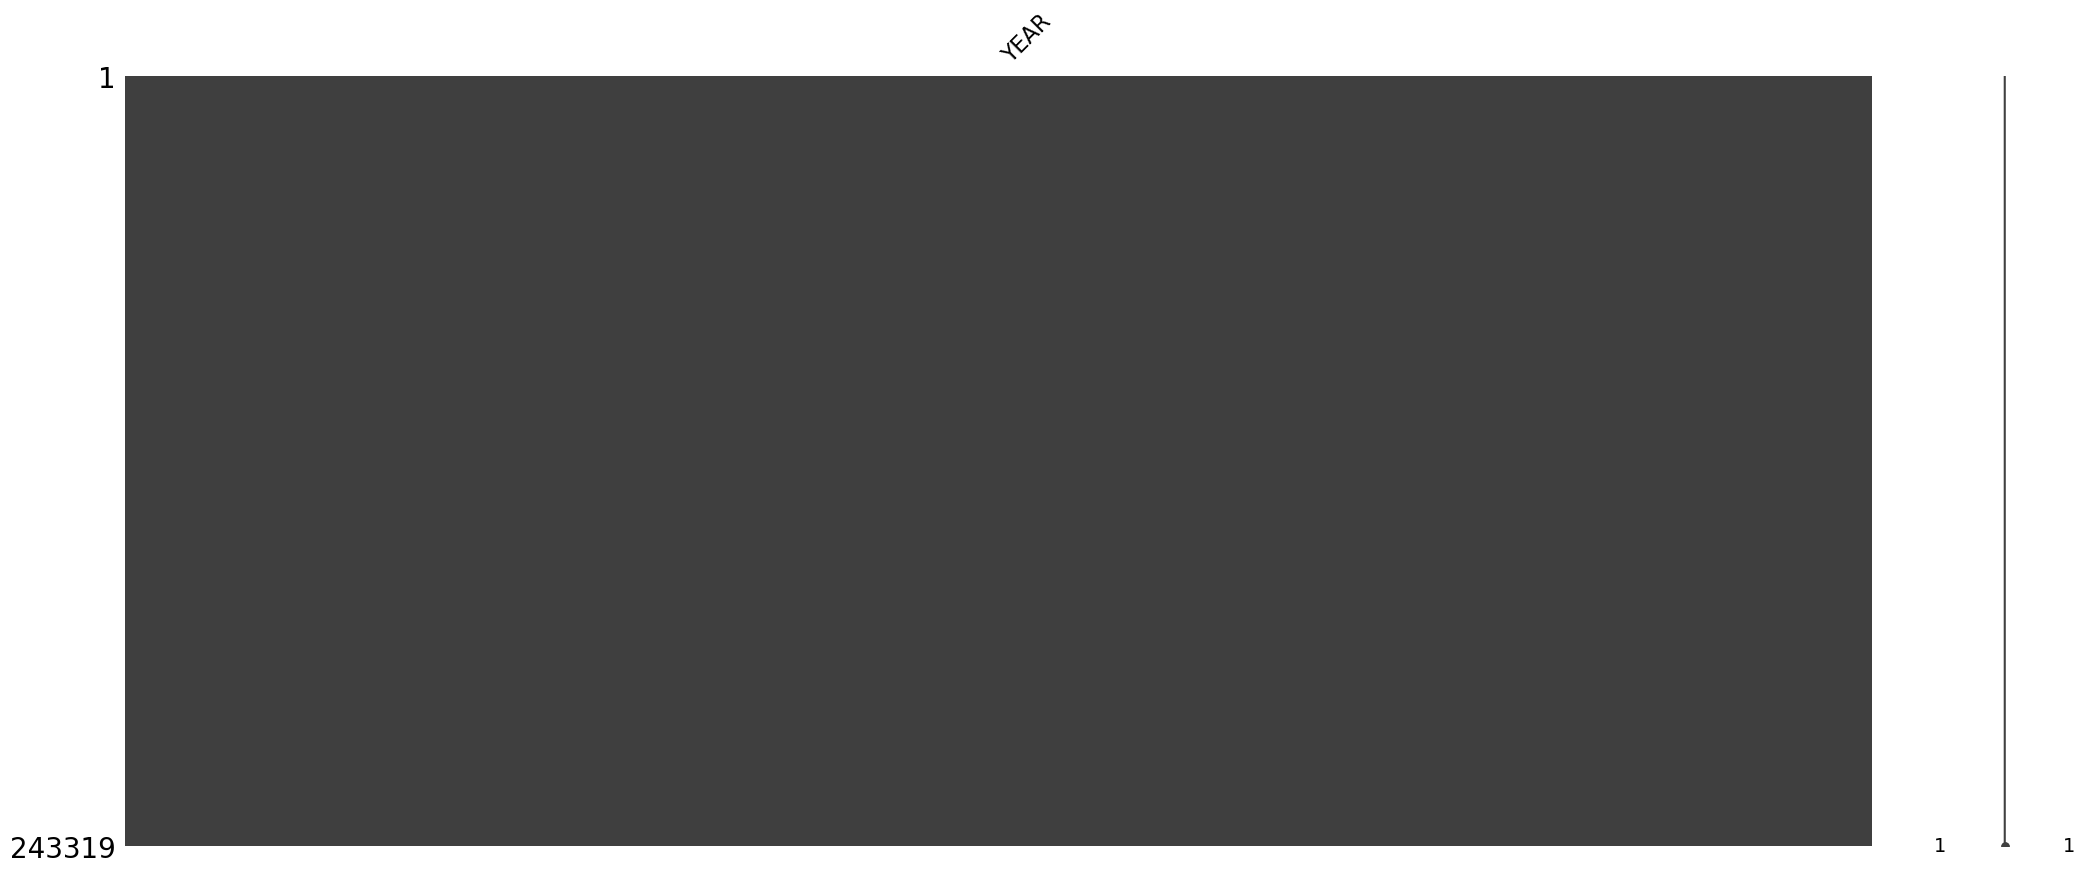

np.int64(0)

In [ ]:

#fill missing Year Built with the median year of its neighborhood
all['YEAR BUILT'] = all.groupby('NEIGHBORHOOD')['YEAR BUILT'].transform(lambda x: x.fillna(x.median()))

cols_with_missing = all.columns[all.isnull().any()].to_list()
cols_with_missing.append('YEAR')

#create a mapping of address to ZIP Code (dropping NaNs first)
zip_lookup = all.dropna(subset=['ZIP CODE']).set_index('ADDRESS')['ZIP CODE'].to_dict()

#fill missing ZIPs by looking up the address in our map
all['ZIP CODE'] = all['ZIP CODE'].fillna(all['ADDRESS'].map(zip_lookup))

#check how many are left
print(f"Missing ZIPs after Address lookup: {all['ZIP CODE'].isna().sum()}") 

#drop remaining rows with missing ZIP CODE
all.dropna(subset=['ZIP CODE'], inplace=True)

#check how many are left
print(f"Missing ZIPs: {all['ZIP CODE'].isna().sum()}") 



all.dropna(subset=['TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT'], inplace=True)

cols_with_missing = all.columns[all.isnull().any()].to_list()
cols_with_missing.append('YEAR')

msno.matrix(all[cols_with_missing].sort_values('YEAR'))
plt.show()

all.isna().sum().sum()



DUPLICATES

In [1082]:
#to remove exact duplicate rows, use built in drop.duplicates function

print("="*60)
print(f"all.shape before removing duplicates:{all.shape}")
all.drop_duplicates(inplace=True)
print(f"all.shape aferremoving duplicates:{all.shape}")

print("="*60)


all.shape before removing duplicates:(243319, 15)
all.shape aferremoving duplicates:(243319, 15)


In [ ]:
#find logical dupes 
print("="*60)
print(f"all.shape before removing duplicates:{all.shape}")

#create the Synthetic Key (BBL)
all['BBL'] = (
    all['BOUROUGH'].astype(str) + "-" + 
    all['BLOCK'].astype(str) + "-" + 
    all['LOT'].astype(str)
)

#this finds cases where the same property sold for the same amount
logical_dupes = all.duplicated(subset=['BBL', 'SALE PRICE', 'SALE DATE']).sum()

print(f"Logical duplicates found: {logical_dupes}")

all.drop_duplicates(subset=['BBL', 'SALE PRICE', 'SALE DATE'], inplace=True)

print("="*60)
print(f"all.shape before removing duplicates:{all.shape}")


all.shape before removing duplicates:(243319, 15)
Logical duplicates found: 2107
all.shape before removing duplicates:(241212, 16)


FORMATTING ISSUES

In [1084]:

all['SALE PRICE'] = all['SALE PRICE'].astype(str).str.replace(',', '').str.strip()

#convert to numeric 
all['SALE PRICE'] = pd.to_numeric(all['SALE PRICE'], errors='coerce')


STATS OF EACH BOROUGH

In [1085]:
#Group by borough and calculate statistics
stats = all.groupby('BOUROUGH')['SALE PRICE'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('25th_percentile', lambda x: x.quantile(0.25)),
    ('75th_percentile', lambda x: x.quantile(0.75))
]).round(2)

stats = stats.sort_values('mean', ascending=False)
print("House Price Statistics by Borough")
print("=" * 60)
print(stats.to_string())




House Price Statistics by Borough
               count        mean    median          std  min        max  25th_percentile  75th_percentile
BOUROUGH                                                                                                 
manhattan      54489  2995695.57  900000.0  18384005.37    0  963000000         360000.0        2125000.0
brooklyn       68786  1110686.74  550000.0   4757023.00    0  317792634              0.0        1200000.0
queens         76187   944788.71  370000.0   6857245.88    0  317792634              0.0         815000.0
bronx          18693   750128.26  300000.0   3318378.52    0  107357142              0.0         725000.0
staten_island  23057   495784.64  465000.0   1056888.95    0   57000000              0.0         715000.0


**Part 2**

Q1:Is there a statistically significant difference in property values between Manhattan and Brooklyn in 2024?

Motivation: This question seeks to quantify the valuation gap between NYC’s two most prominent boroughs during the recovery phase. By determining if a "significant" difference exists, we can conclude whether Manhattan has maintained its traditional market lead or if Brooklyn has narrowed the gap post-COVID.

Q2: Has there been a statistically significant change in Brooklyn property prices between 2023 and 2024?

Motivation: We aim to measure the current momentum of the market. By comparing consecutive years (2023 vs. 2024) we reveal whether the recovery is still actively climbing or if prices have started to stabilize. Using Welch’s T-test adds validity, as it accounts for fluctuations in sample sizes and price volatility in year-over-year real estate data.

To evaluate the post-COVID NYC real estate recovery, first compares Manhattan and Brooklyn property values for 2024. We use an Independent Two-Sample T-test to determine if there is a statistically significant price difference between these two boroughs. 

Next, we compare Brooklyn property prices between 2023 and 2024. We use Welch’s T-test to see if the price change over this one-year period is statistically significant. This test is chosen because it handles the different sample sizes and price variations found in year-over-year real estate data.

In [1086]:
from scipy import stats

df_subset = all[(all['YEAR'].isin([2023, 2024])) & 
                (all['BOUROUGH'].isin(['manhattan', 'brooklyn']))].copy()

#filter out $0 or ultra-low sales and missing prices
df_subset = df_subset[df_subset['SALE PRICE'] > 10000].dropna(subset=['SALE PRICE'])

#hypothesis test 1: Manhattan vs Brooklyn (2024)
manhattan_2024 = df_subset[(df_subset['BOUROUGH'] == 'manhattan') & (df_subset['YEAR'] == 2024)]['SALE PRICE']
brooklyn_2024 = df_subset[(df_subset['BOUROUGH'] == 'brooklyn') & (df_subset['YEAR'] == 2024)]['SALE PRICE']

t_stat, p_val = stats.ttest_ind(manhattan_2024, brooklyn_2024, equal_var=False)

print("=" *60)
print(f"Test 1 (Manhattan vs Brooklyn 2024):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4e}")
print("=" *60)

#hypothesis Test 2: Brooklyn 2023 vs Brooklyn 2024
bk_2023 = df_subset[(df_subset['BOUROUGH'] == 'brooklyn') & (df_subset['YEAR'] == 2023)]['SALE PRICE']
bk_2024 = df_subset[(df_subset['BOUROUGH'] == 'brooklyn') & (df_subset['YEAR'] == 2024)]['SALE PRICE']

t_stat2, p_val2 = stats.ttest_ind(bk_2023, bk_2024, equal_var=False)
print("=" *60)
print(f"Test 2 (Brooklyn 2023 vs 2024):")
print(f"T-statistic: {t_stat2:.4f}, P-value: {p_val2:.4f}")
print("=" *60)

Test 1 (Manhattan vs Brooklyn 2024):
T-statistic: 10.9839, P-value: 5.7850e-28
Test 2 (Brooklyn 2023 vs 2024):
T-statistic: -0.6458, P-value: 0.5184


CONCLUSIONS: 

To assess how the NYC housing market is recovering after the pandemic, our first analysis compared home prices in Manhattan and Brooklyn for 2024. The results showed a high T-statistic of 10.98 and a P-value of nearly zero ($5.78 \times 10^{-28}$). This indicates that the price difference between the two boroughs is statistically significant and not due to chance. Essentially, Manhattan has maintained its position as the most expensive borough, confirming that its market premium over Brooklyn remains firmly in place.

Next, we looked at Brooklyn specifically to see if prices changed significantly between 2023 and 2024. This test resulted in a P-value of 0.5184, which is well above the standard 0.05 threshold. This means there is no statistically significant difference in prices between those two years. These findings suggest that the rapid price growth Brooklyn experienced in the immediate post-pandemic years has stabilized, and the market there is currently in a plateau phase.

Overall, the results show that while the recovery was initially volatile, the traditional price hierarchy between these boroughs has returned and the aggressive price spikes have slowed down.